<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Глобальные-параметры" data-toc-modified-id="Глобальные-параметры-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Глобальные параметры</a></span></li><li><span><a href="#Библиотеки-для-работы" data-toc-modified-id="Библиотеки-для-работы-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Библиотеки для работы</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Оценка-баланса-классов-в-таргете" data-toc-modified-id="Оценка-баланса-классов-в-таргете-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Оценка баланса классов в таргете</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Проверка-на-дубликаты-и-пропуски-в-лемматизированном-датасете" data-toc-modified-id="Проверка-на-дубликаты-и-пропуски-в-лемматизированном-датасете-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Проверка на дубликаты и пропуски в лемматизированном датасете</a></span></li><li><span><a href="#Итоговый-датасет-перед-обучением-моделей" data-toc-modified-id="Итоговый-датасет-перед-обучением-моделей-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Итоговый датасет перед обучением моделей</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-фич-через-TF-IDF" data-toc-modified-id="Подготовка-фич-через-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка фич через TF-IDF</a></span></li><li><span><a href="#CatBoost-+-TF-IDF" data-toc-modified-id="CatBoost-+-TF-IDF-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost + TF-IDF</a></span></li><li><span><a href="#BERT-Embedding" data-toc-modified-id="BERT-Embedding-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT Embedding</a></span></li><li><span><a href="#CatBoost-+-BERT" data-toc-modified-id="CatBoost-+-BERT-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoost + BERT</a></span></li><li><span><a href="#Сравнение-результатов-обучения" data-toc-modified-id="Сравнение-результатов-обучения-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнение результатов обучения</a></span></li></ul></li><li><span><a href="#Проверка-на-тесте" data-toc-modified-id="Проверка-на-тесте-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка на тесте</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Глобальные параметры

In [1]:
SEED = 12345 #random_state
ITERATIONS = 5 # iterations

### Библиотеки для работы

- `catboost` - основной классификатор с возможностью запуска на GPU, что выгодно для больших матриц
- `nltk` - работа с лемматизацией и словарем
- `numpy`, `pandas`, `torch` - датасеты, массивы, тензоры
- `re` - регулярные выражения
- `sklearn` - работа с выборками и моделями МО
- `matplotlib`, `seaborn` - графики
- `transformers` - работа с моделью BERT
- `tqdm` - таймер циклов

In [2]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
import spacy
import torch
import transformers
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

### Загрузка датасета

Грузим с сервера данные:

In [4]:
df = pd.read_csv('./datasets/toxic_comments.csv', index_col=[0]).reset_index(drop=True)

И смотрим на формат строк:

In [5]:
df.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


### Оценка баланса классов в таргете

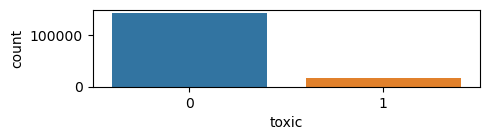

In [6]:
plt.figure(figsize=(5,1))
sns.countplot(data=df,
              x='toxic');

In [7]:
df['toxic'].value_counts(normalize=True)

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64

Задаем параметр баланса классов для CatBoostClassifier:

In [8]:
SCALE = 1/(df['toxic'].value_counts(normalize=True)[1])
SCALE

9.841344371679229

### Лемматизация

Инициируем лемматизацию `spaCy`:

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
def lemmatize(text):
    # лемматизируем каждый из них
    lemmatized_tokens = ' '.join([token.lemma_ for token in nlp(text)])
    return lemmatized_tokens

In [11]:
def clear_text(text):
    # оставляем только латинницу
    text = text.lower()
    text = ' '.join(re.sub(r'[^a-z]', ' ', text).split()) 
    #text = ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split()) 
    # убираем артикли
    text = text.replace(' the ', ' ') 
    text = text.replace('the ', '') 
    text = text.replace(' a ', ' ' )
    text = text.replace('a ', '')
    # убираем повторные пробелы и пробелы в начале и конце строк
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

Очищаем текст от знаков препинания, артиклей и пробелов:

In [12]:
df['clear'] = df['text'].apply(clear_text)

Проводим лемматизацию форм:

In [13]:
%%time
df['lemm'] = df['clear'].apply(lemmatize)

CPU times: total: 7min 28s
Wall time: 7min 53s


In [14]:
df = df[['lemm', 'text', 'toxic']]

### Проверка на дубликаты и пропуски в лемматизированном датасете

In [15]:
# полные дубликаты
print(df.duplicated().sum())
df = df.drop_duplicates()

0


In [16]:
# пропуски
print(df.isna().sum())
df = df.dropna()

lemm     0
text     0
toxic    0
dtype: int64


### Итоговый датасет перед обучением моделей

In [17]:
df.head(3)

,lemm,text,toxic
0,explanation why edit make under my username ha...,Explanation\nWhy the edits made under my usern...,0
1,d aww he match this background colour I m seem...,D'aww! He matches this background colour I'm s...,0
2,hey man I m really not try to edit war it s ju...,"Hey man, I'm really not trying to edit war. It...",0


## Обучение

Разбивка на трейн и тест:

In [18]:
train, test = train_test_split(df, test_size=0.25, random_state=SEED)

Таргетные столбцы для моделей:

In [19]:
y_train = train['toxic'] 
y_test = test['toxic']

### Подготовка фич через TF-IDF

Подготовим фичи через `TF-IDF`:

In [20]:
# корпуса
corpus_train = train['lemm']
corpus_test = test['lemm']

In [21]:
# фильтр стоп слов
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


При запуске векторизации для экономии памяти и времени установим параметр `max_feautures` = 500:

In [22]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords,
                               max_features=500) 

Обучающая и тестовая выборки:

In [23]:
x_train_tfidf = count_tf_idf.fit_transform(corpus_train)
x_test_tfidf = count_tf_idf.transform(corpus_test)

In [24]:
x_train_tfidf.shape

(119469, 500)

### CatBoost + TF-IDF

Делаем рандом-серч c поиском лучших `iterations`, `learning_rate`, `depth`, `l2_leaf_reg`. Для учета дисбаланса классов выставляем `scale_pos_weight` = SCALE:

In [25]:
cbc_tfidf = CatBoostClassifier(random_state=SEED,
                         task_type='GPU',
                         scale_pos_weight=SCALE,
                         verbose=250,
                         iterations=1000,
                         eval_metric='F1')

In [26]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [2, 4, 8],
              'l2_leaf_reg': [1, 5]
              }

In [27]:
%%time
cbc_tfidf_rs = cbc_tfidf.randomized_search(parameters,
                               X=x_train_tfidf,
                               y=y_train,
                               n_iter=ITERATIONS,
                               cv=4,
                               partition_random_seed=SEED,
                               verbose=1)

0:	learn: 0.4392115	test: 0.4280721	best: 0.4280721 (0)	total: 29.5ms	remaining: 29.4s
250:	learn: 0.7959071	test: 0.7816407	best: 0.7975509 (69)	total: 7.71s	remaining: 23s
500:	learn: 0.8425820	test: 0.8324584	best: 0.8326813 (498)	total: 15.5s	remaining: 15.4s
750:	learn: 0.8508445	test: 0.8326712	best: 0.8333919 (541)	total: 22.8s	remaining: 7.57s
999:	learn: 0.8569836	test: 0.8327869	best: 0.8346277 (943)	total: 30.2s	remaining: 0us
bestTest = 0.834627688
bestIteration = 943
0:	loss: 0.8346277	best: 0.8346277 (0)	total: 30.4s	remaining: 2m 1s
0:	learn: 0.5645953	test: 0.5379246	best: 0.5379246 (0)	total: 154ms	remaining: 2m 33s
250:	learn: 0.7580629	test: 0.7409313	best: 0.7887299 (81)	total: 34.6s	remaining: 1m 43s
500:	learn: 0.7858868	test: 0.7711446	best: 0.7887299 (81)	total: 1m 8s	remaining: 1m 7s
750:	learn: 0.7979902	test: 0.7806214	best: 0.7887299 (81)	total: 1m 32s	remaining: 30.5s
999:	learn: 0.8046543	test: 0.7830526	best: 0.7887299 (81)	total: 1m 50s	remaining: 0us
be

In [28]:
cbc_tfidf_rs['params']

{'depth': 8, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

In [29]:
print(f'Метрика F1 для кросс-валидации CatBoostClassifier+TF-IDF', max(cbc_tfidf_rs['cv_results']['test-F1-mean']))

Метрика F1 для кросс-валидации CatBoostClassifier+TF-IDF 0.8297352815902381


### BERT Embedding

Будем использовать предобученную модель `bert-large-uncased`:

In [30]:
model_name = 'bert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Готовим список инпутов и attention_masks для каждого предложения столбца `lemm` в датафрейме df. Берем сырой текст без предобработки. На выходе два тензора для передачи в модель BERT:
- Ограничим длину строки max_length = 200 (для ускорения далнейших тензорных вычислений)
- Добавляем специальные токены начала и конца предложения
- Выполняем паддинг и возвращаем данные в виде тензоров `PyTorch`

In [31]:
%%time
input_ids = []
attention_masks = []

for sentence in tqdm(df['text']):
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=200,
        truncation=True,
        pad_to_max_length='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
input_ids.shape, attention_masks.shape

  0%|                                                                                       | 0/159292 [00:00<?, ?it/s]C:\ProgramData\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [00:47<00:00, 3388.27it/s]


CPU times: total: 13.8 s
Wall time: 47.4 s


(torch.Size([159292, 200]), torch.Size([159292, 200]))

Собираем эмбеддинги из тензора `PyTorch` в датафрейм features:

In [32]:
%%time
batch_size = 128
embeddings = []
with torch.no_grad():
    for i in tqdm(range(0, len(df), batch_size)):
        input_ids_batch = input_ids[i:i+batch_size].to(device)
        attention_masks_batch = attention_masks[i:i+batch_size].to(device)
        embeddings_batch = model.to(device)(input_ids_batch, attention_mask=attention_masks_batch)
        embeddings.append(embeddings_batch[0][:,0,:].cpu().numpy())
        del input_ids_batch
        del attention_masks_batch
        del embeddings_batch
features = np.concatenate(embeddings)

100%|██████████████████████████████████████████████████████████████████████████████| 1245/1245 [05:47<00:00,  3.58it/s]


CPU times: total: 5min 16s
Wall time: 5min 47s


Готовим выборки фич на основе BERT:

In [33]:
x_train_bert, x_test_bert = train_test_split(features, test_size=0.25, random_state=SEED)
x_train_bert.shape, x_test_bert.shape

((119469, 768), (39823, 768))

### CatBoost + BERT

Повторяем рандом серч с параметрами из пункта 2.2:

In [34]:
cbc_bert = CatBoostClassifier(random_state=SEED,
                         task_type='GPU',
                         scale_pos_weight=SCALE,
                         verbose=250,
                         iterations=1000,
                         eval_metric='F1')

In [35]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [2, 4, 8],
              'l2_leaf_reg': [1, 3]
              }

In [36]:
%%time
cbc_bert_rs = cbc_bert.randomized_search(parameters,
                                         X=x_train_bert,
                                         y=y_train,
                                         n_iter=ITERATIONS,
                                         cv=4,
                                         partition_random_seed=SEED,
                                         verbose=1)

0:	learn: 0.7483102	test: 0.7510961	best: 0.7510961 (0)	total: 34.3ms	remaining: 34.3s
250:	learn: 0.8930542	test: 0.8853027	best: 0.8854198 (246)	total: 8.96s	remaining: 26.7s
500:	learn: 0.9058155	test: 0.8869715	best: 0.8886803 (379)	total: 18.1s	remaining: 18s
750:	learn: 0.9155859	test: 0.8891891	best: 0.8903721 (715)	total: 27.2s	remaining: 9.02s
999:	learn: 0.9252243	test: 0.8896489	best: 0.8908972 (846)	total: 36.2s	remaining: 0us
bestTest = 0.8908971534
bestIteration = 846
0:	loss: 0.8908972	best: 0.8908972 (0)	total: 37s	remaining: 2m 27s
0:	learn: 0.8120790	test: 0.8086266	best: 0.8086266 (0)	total: 216ms	remaining: 3m 35s
250:	learn: 0.8897238	test: 0.8733795	best: 0.8733795 (249)	total: 50.3s	remaining: 2m 30s
500:	learn: 0.8925678	test: 0.8753671	best: 0.8759820 (482)	total: 1m 6s	remaining: 1m 6s
750:	learn: 0.8956785	test: 0.8779504	best: 0.8779504 (746)	total: 1m 21s	remaining: 27s
999:	learn: 0.8977730	test: 0.8784312	best: 0.8790180 (889)	total: 1m 35s	remaining: 0us

In [37]:
cbc_bert_rs['params']

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [38]:
print(f'Метрика F1 для кросс-валидации CatBoostClassifier+BERT', max(cbc_bert_rs['cv_results']['test-F1-mean']))

Метрика F1 для кросс-валидации CatBoostClassifier+BERT 0.8866821174731474


### Сравнение результатов обучения

In [39]:
result = pd.DataFrame({'F1-score' : [max(cbc_tfidf_rs['cv_results']['test-F1-mean']),
                       max(cbc_bert_rs['cv_results']['test-F1-mean'])]}, index=['CB+TFIDF', 'CB+BERT'])
result

,F1-score
CB+TFIDF,0.829735
CB+BERT,0.886682


С фичами BERT валидационный скор выше.

## Проверка на тесте

Лучшей моделью по валидации выбрана CatBoostClassifier + Bert Embedding:

In [43]:
cbc_bert = CatBoostClassifier(iterations=1000,
                              random_state=SEED,
                              task_type='CPU',
                              scale_pos_weight=SCALE,
                              verbose=False,
                              eval_metric='F1',
                              **cbc_bert_rs['params'])

In [44]:
cbc_bert.fit(x_train_bert, y_train, eval_set=(x_test_bert, y_test), verbose=200, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7493587	test: 0.7429882	best: 0.7429882 (0)	total: 60.9ms	remaining: 1m
200:	learn: 0.8835524	test: 0.8732270	best: 0.8735816 (199)	total: 8.53s	remaining: 33.9s
400:	learn: 0.8985484	test: 0.8805685	best: 0.8809436 (397)	total: 16.2s	remaining: 24.2s
600:	learn: 0.9085674	test: 0.8840256	best: 0.8843281 (599)	total: 23.8s	remaining: 15.8s
800:	learn: 0.9178252	test: 0.8837469	best: 0.8849188 (767)	total: 31.3s	remaining: 7.78s
999:	learn: 0.9249492	test: 0.8844931	best: 0.8853835 (883)	total: 38.8s	remaining: 0us

bestTest = 0.8853834522
bestIteration = 883

Shrink model to first 884 iterations.


In [45]:
cbc_bert.best_score_['validation']['F1']

0.8853834522487388

**Модель CatBoost + BERT прошла проверку на F1 > 0.75**

## Выводы

**Выводы** 
- Протестированы два подхода к созданию фич для NLP: TF-IDF, BERT эмбеддинг
- Обучены модели с применением рандом-серча параметров и кросс-валидации
- Лучшей моделью показала себя CatBoostClassifier + Bert Embedding с тестовым скором 0.88

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны